In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_str


('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
last_date = dt.date.fromisoformat(most_recent_date_str[0])

# Calculate the date one year from the last date in data set.
one_year_before_last_date = last_date + relativedelta(years=-1)

# Perform a query to retrieve the data and precipitation scores
last12months_data = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date.between(one_year_before_last_date, last_date))\
                            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last12months_df = pd.DataFrame(last12months_data)
last12months_df.columns = ["date", "precipitation"]

# Convert date strings to datetime values
last12months_df["date"] = last12months_df["date"].astype('datetime64[ns]')

# Sort the dataframe by date
last12months_df = last12months_df.sort_values(by=["date"])


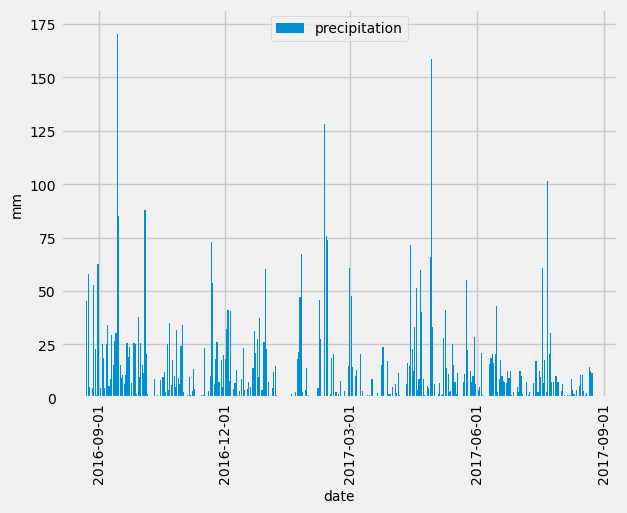

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

# Prepare dataframe for plotting - set dataframe index to the Date column values 
last12months_df.set_index("date", inplace=True)

# First attempted using Pandas dataframe-style plotting...
# last12months_df.plot(kind = "bar")
# ...but had trouble with getting x-axis date label values to work, so reverted to matplotlib-style approach.
# Reference:
# https://stackoverflow.com/questions/64919511/dateformatter-is-bringing-1970-as-year-not-the-original-year-in-the-dataset

# Configure a bar chart
fig, ax = plt.subplots()
ax.bar(last12months_df.index.values, last12months_df["precipitation"])
# Apply axis labels and Legend
ax.set_ylabel("mm", fontsize=10)
ax.set_xlabel("date", fontsize=10)
ax.legend(["precipitation"], loc="upper center", fontsize=10)
# Enable a background grid
ax.grid(True)
# Set x-axis (Date) labels every 3 months, and rotate them 90 degrees
locator = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
x_labels = ax.get_xticklabels()
plt.setp(x_labels, rotation=90, fontsize=10)
# Set y-axis labels and upper limit
y_labels = ax.get_yticklabels()
plt.setp(y_labels, fontsize=10)
plt.ylim((0,round(last12months_df["precipitation"].max()) + 12))

# Display the plot with the above features
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
last12months_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station.id).count()
number_of_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Station.station, func.count(Measurement.station))\
    .join(Measurement, Station.station == Measurement.station)\
    .group_by(Station.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .join(Station, Station.station == Measurement.station)\
        .filter(Station.station == most_active_station_id)\
        .all()

[(12.2, 29.4, 22.035822510822513)]

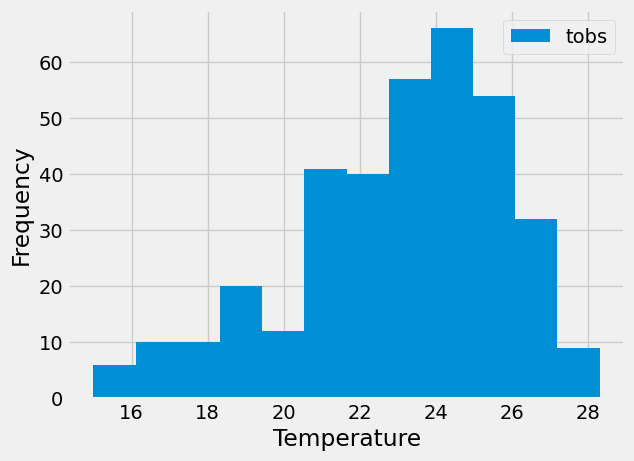

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent observation date for this station
most_recent_date_str = session.query(func.max(Measurement.date))\
    .filter(Measurement.station == most_active_station_id)\
    .one()

# Convert to a date type and calculate the date one year earlier
last_date = dt.date.fromisoformat(most_recent_date_str[0])
one_year_before_last_date = last_date + relativedelta(years=-1)

# Define a query to retrieve the temperature observation data for this station
last12months_data = session.query(Measurement.tobs)\
                            .filter(Measurement.date.between(one_year_before_last_date, last_date))\
                            .filter(Measurement.station == most_active_station_id)

# Save the query results as a Pandas DataFrame
last12months_df = pd.DataFrame(last12months_data)

# Plot the temperature observation results as a histogram
ax = last12months_df.plot(kind='hist', bins=12)
ax.set_xlabel("Temperature")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()
